## Import libraries

In [1]:
! pip install impyute

In [2]:
import pickle
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from impyute.imputation.cs import mice
from sklearn.preprocessing import QuantileTransformer

## Load train/test datasets

In [3]:
train_df = pd.read_csv("../input/reduce-marketing-waste/dataset/train.csv")
test_df = pd.read_csv("../input/reduce-marketing-waste/dataset/test.csv")
print("train_df: {} \ntest_df:{}".format(train_df.shape, test_df.shape))

train_df: (7007, 23) 
test_df:(2093, 22)


In [4]:
"""
Observations:
-------------
1) Except "Internal_rating", rest all columns are string datatype
2) NaN values present in below columns:
    a) Industry
    b) Deal_value
    c) Weighted_amount
    d) Geography
    e) Location
    f) POC_name
    g) Last_lead_update
    h) Resource
"""

train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7007 entries, 0 to 7006
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Deal_title             7007 non-null   object 
 1   Lead_name              7007 non-null   object 
 2   Industry               7006 non-null   object 
 3   Deal_value             6956 non-null   object 
 4   Weighted_amount        6482 non-null   object 
 5   Date_of_creation       7007 non-null   object 
 6   Pitch                  7007 non-null   object 
 7   Contact_no             7007 non-null   object 
 8   Lead_revenue           7007 non-null   object 
 9   Fund_category          7007 non-null   object 
 10  Geography              6035 non-null   object 
 11  Location               6996 non-null   object 
 12  POC_name               6999 non-null   object 
 13  Designation            7007 non-null   object 
 14  Lead_POC_email         7007 non-null   object 
 15  Hiri

In [5]:
missing_data = pd.DataFrame(1 - train_df.count() / len(train_df), columns=['%missing (train)'])
missing_data['%missing (test)'] = 1 - test_df.count() / len(test_df)
missing_data.head(25)

,%missing (train),%missing (test)
Deal_title,0.000000,0.000000
Lead_name,0.000000,0.000000
Industry,0.000143,0.000478
Deal_value,0.007278,0.002389
Weighted_amount,0.074925,0.028667
Date_of_creation,0.000000,0.000000
Pitch,0.000000,0.000000
Contact_no,0.000000,0.000000
Lead_revenue,0.000000,0.000000
Fund_category,0.000000,0.000000


## Data Cleansing

In [6]:
"""
1) Deal_title: Represents a unique title for each deal --> Set as index
2) Deal_value: Represents the value of a deal between a lead and your company         --> Remove $ sign at end
3) Weighted_amount: Represents a value that is estimated revenue times a probability  --> Remove $ sign at end
4) Contact_no: Represents the contact details of a lead    --> No similarity between train & test; drop column
5) POC_name: Represents the lead's point of contact's name --> Not much similarity between train & test; drop column
6) Lead_POC_email: Represents the lead POC's email address --> Not much similarity between train & test; drop column
"""

train_df.set_index('Deal_title', inplace=True)
test_df.set_index('Deal_title', inplace=True)

train_df['Deal_value'] = train_df['Deal_value'].apply(lambda x: float(x[:-1]) if str(x).endswith("$") else x)
train_df['Weighted_amount'] = train_df['Weighted_amount'].apply(lambda x: float(x[:-1]) if str(x).endswith("$") else x)

test_df['Deal_value'] = test_df['Deal_value'].apply(lambda x: float(x[:-1]) if str(x).endswith("$") else x)
test_df['Weighted_amount'] = test_df['Weighted_amount'].apply(lambda x: float(x[:-1]) if str(x).endswith("$") else x)

train_df.drop(['Contact_no','POC_name','Lead_POC_email'], axis=1, inplace=True)
test_df.drop(['Contact_no','POC_name','Lead_POC_email'], axis=1, inplace=True)

train_df.head()

,Lead_name,Industry,Deal_value,Weighted_amount,Date_of_creation,Pitch,Lead_revenue,Fund_category,Geography,Location,Designation,Hiring_candidate_role,Lead_source,Level_of_meeting,Last_lead_update,Internal_POC,Resource,Internal_rating,Success_probability
Deal_title,,,,,,,,,,,,,,,,,,,
TitleM5DZY,"Davis, Perkins and Bishop Inc",Restaurants,320506.0,2067263.7,2020-03-29,Product_2,50 - 100 Million,Category 2,USA,"Killeen-Temple, TX",Executive Vice President,Community pharmacist,Website,Level 3,No track,"Davis,Sharrice A",NaN,3,73.6
TitleKIW18,Bender PLC LLC,Construction Services,39488.0,240876.8,2019-07-10,Product_2,500 Million - 1 Billion,Category 4,India,Ratlam,Chairman/CEO/President,Recruitment consultant,Others,Level 1,Did not hear back after Level 1,"Brown,Maxine A",No,5,58.9
TitleFXSDN,Carter-Henry and Sons,Hospitals/Clinics,359392.0,2407926.4,2019-07-27,Product_1,500 Million - 1 Billion,Category 4,USA,"Albany-Schenectady-Troy, NY",SVP/General Counsel,Health service manager,Marketing Event,Level 1,?,"Georgakopoulos,Vasilios T",No,4,68.8
TitlePSK4Y,Garcia Ltd Ltd,Real Estate,76774.0,468321.4,2021-01-30,Product_2,500 Million - 1 Billion,Category 3,USA,"Mount Vernon-Anacortes, WA",CEO/Co-Founder/Chairman,"Therapist, speech and language",Contact Email,Level 2,Did not hear back after Level 1,"Brown,Maxine A",We have all the requirements,1,64.5
Title904GV,Lee and Sons PLC,Financial Services,483896.0,NaN,2019-05-22,Product_2,50 - 100 Million,Category 3,India,Shimoga,Executive Vice President,Media planner,Website,Level 2,Up-to-date,"Thomas,Lori E",No,4,62.4


## Extract target label

In [7]:
train_df['Success_probability'] = train_df['Success_probability'].apply(lambda x: 0 if x<0 else 100 if x>100 else x)

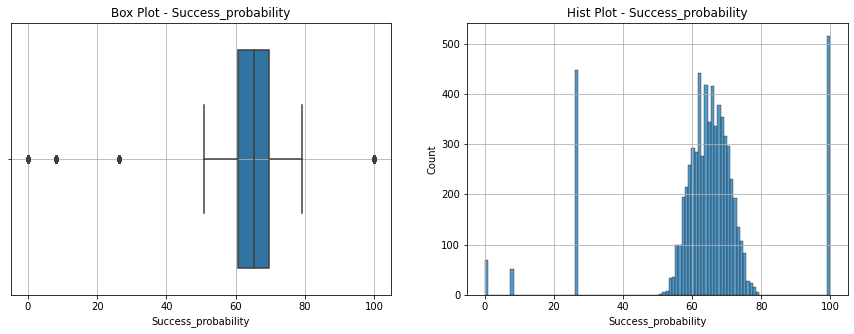

In [8]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x='Success_probability', data=train_df, ax=ax[0])
sns.histplot(x='Success_probability', data=train_df, ax=ax[1])
ax[0].title.set_text('Box Plot - Success_probability'); ax[0].grid();
ax[1].title.set_text('Hist Plot - Success_probability'); ax[1].grid();

In [9]:
train_y = train_df['Success_probability'].values
train_df.drop(['Success_probability'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))

train_y: (7007,)


## Feature Engineering

### Combine train/test datasets

In [10]:
combined_df = train_df.append(test_df, sort=False, ignore_index=False)
print(combined_df.shape)
combined_df.head()

(9100, 18)


,Lead_name,Industry,Deal_value,Weighted_amount,Date_of_creation,Pitch,Lead_revenue,Fund_category,Geography,Location,Designation,Hiring_candidate_role,Lead_source,Level_of_meeting,Last_lead_update,Internal_POC,Resource,Internal_rating
Deal_title,,,,,,,,,,,,,,,,,,
TitleM5DZY,"Davis, Perkins and Bishop Inc",Restaurants,320506.0,2067263.7,2020-03-29,Product_2,50 - 100 Million,Category 2,USA,"Killeen-Temple, TX",Executive Vice President,Community pharmacist,Website,Level 3,No track,"Davis,Sharrice A",NaN,3.0
TitleKIW18,Bender PLC LLC,Construction Services,39488.0,240876.8,2019-07-10,Product_2,500 Million - 1 Billion,Category 4,India,Ratlam,Chairman/CEO/President,Recruitment consultant,Others,Level 1,Did not hear back after Level 1,"Brown,Maxine A",No,5.0
TitleFXSDN,Carter-Henry and Sons,Hospitals/Clinics,359392.0,2407926.4,2019-07-27,Product_1,500 Million - 1 Billion,Category 4,USA,"Albany-Schenectady-Troy, NY",SVP/General Counsel,Health service manager,Marketing Event,Level 1,?,"Georgakopoulos,Vasilios T",No,4.0
TitlePSK4Y,Garcia Ltd Ltd,Real Estate,76774.0,468321.4,2021-01-30,Product_2,500 Million - 1 Billion,Category 3,USA,"Mount Vernon-Anacortes, WA",CEO/Co-Founder/Chairman,"Therapist, speech and language",Contact Email,Level 2,Did not hear back after Level 1,"Brown,Maxine A",We have all the requirements,1.0
Title904GV,Lee and Sons PLC,Financial Services,483896.0,NaN,2019-05-22,Product_2,50 - 100 Million,Category 3,India,Shimoga,Executive Vice President,Media planner,Website,Level 2,Up-to-date,"Thomas,Lori E",No,4.0


### Lead_name

In [11]:
combined_df['Lead_name_type'] = combined_df['Lead_name'].apply(lambda x: x.split()[-1])
combined_df['Lead_name_type'] = combined_df['Lead_name_type'].factorize()[0]
combined_df.groupby(['Lead_name_type']).size().reset_index().rename(columns={0:'count'})

,Lead_name_type,count
0,0,1481
1,1,1564
2,2,1517
3,3,1534
4,4,1451
5,5,1553


### Date_of_creation

In [12]:
combined_df['create_dt_year'] = combined_df['Date_of_creation'].map(lambda x: pd.to_datetime(x).year)
combined_df['create_dt_quarter'] = combined_df['Date_of_creation'].map(lambda x: pd.to_datetime(x).quarter)
combined_df['create_dt_month'] = combined_df['Date_of_creation'].map(lambda x: pd.to_datetime(x).month)
combined_df['create_dt_week'] = combined_df['Date_of_creation'].map(lambda x: pd.to_datetime(x).week)
combined_df['create_dt_day_year'] = combined_df['Date_of_creation'].map(lambda x: pd.to_datetime(x).dayofyear)
combined_df['create_dt_day_month'] = combined_df['Date_of_creation'].map(lambda x: pd.to_datetime(x).day)
combined_df['create_dt_day_week'] = combined_df['Date_of_creation'].map(lambda x: pd.to_datetime(x).dayofweek)
combined_df['create_dt_day_weekend'] = np.where(combined_df['create_dt_day_week'].isin([5,6]),1,0)

In [13]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [14]:
combined_df = encode(combined_df, 'create_dt_quarter', 4)
combined_df = encode(combined_df, 'create_dt_month', 12)
combined_df = encode(combined_df, 'create_dt_week', 53)
combined_df = encode(combined_df, 'create_dt_day_month', 31)
combined_df = encode(combined_df, 'create_dt_day_week', 7)

### Pitch, Lead_revenue, Fund_category

In [15]:
combined_df['Pitch'] = combined_df['Pitch'].factorize()[0]
combined_df['Lead_revenue'] = combined_df['Lead_revenue'].factorize()[0]
combined_df['Fund_category'] = combined_df['Fund_category'].factorize()[0]
combined_df.head()

,Lead_name,Industry,Deal_value,Weighted_amount,Date_of_creation,Pitch,Lead_revenue,Fund_category,Geography,Location,...,create_dt_quarter_sin,create_dt_quarter_cos,create_dt_month_sin,create_dt_month_cos,create_dt_week_sin,create_dt_week_cos,create_dt_day_month_sin,create_dt_day_month_cos,create_dt_day_week_sin,create_dt_day_week_cos
Deal_title,,,,,,,,,,,,,,,,,,,,,
TitleM5DZY,"Davis, Perkins and Bishop Inc",Restaurants,320506.0,2067263.7,2020-03-29,0,0,0,USA,"Killeen-Temple, TX",...,1.000000e+00,6.123234e-17,1.0,6.123234e-17,0.999561,0.029633,-0.394356,0.918958,-0.781831,0.623490
TitleKIW18,Bender PLC LLC,Construction Services,39488.0,240876.8,2019-07-10,0,1,1,India,Ratlam,...,-1.000000e+00,-1.836970e-16,-0.5,-8.660254e-01,-0.176890,-0.984231,0.897805,-0.440394,0.974928,-0.222521
TitleFXSDN,Carter-Henry and Sons,Hospitals/Clinics,359392.0,2407926.4,2019-07-27,1,1,1,USA,"Albany-Schenectady-Troy, NY",...,-1.000000e+00,-1.836970e-16,-0.5,-8.660254e-01,-0.403123,-0.915146,-0.724793,0.688967,-0.974928,-0.222521
TitlePSK4Y,Garcia Ltd Ltd,Real Estate,76774.0,468321.4,2021-01-30,0,1,2,USA,"Mount Vernon-Anacortes, WA",...,1.000000e+00,6.123234e-17,0.5,8.660254e-01,0.456629,0.889657,-0.201299,0.979530,-0.974928,-0.222521
Title904GV,Lee and Sons PLC,Financial Services,483896.0,NaN,2019-05-22,0,0,2,India,Shimoga,...,1.224647e-16,-1.000000e+00,0.5,-8.660254e-01,0.606800,-0.794854,-0.968077,-0.250653,0.974928,-0.222521


### Geography, Location

In [16]:
geography_map = {
    'India': 0,
    'USA': 1
}
combined_df['Geography'] = combined_df['Geography'].map(geography_map)
combined_df.groupby(['Geography']).size().reset_index().rename(columns={0:'count'})

,Geography,count
0,0.0,3986
1,1.0,4063


### Industry, Hiring_candidate_role

In [17]:
combined_df["Industry"].fillna("Alternative", inplace=True)
combined_df["Industry"] = combined_df["Industry"].apply(lambda x: 'BSPs (Broadband)' if x=='NSPs (Network)' else x)
combined_df['Industry'] = combined_df['Industry'].factorize()[0]
combined_df['Hiring_candidate_role'] = combined_df['Hiring_candidate_role'].factorize()[0]
combined_df.head()

,Lead_name,Industry,Deal_value,Weighted_amount,Date_of_creation,Pitch,Lead_revenue,Fund_category,Geography,Location,...,create_dt_quarter_sin,create_dt_quarter_cos,create_dt_month_sin,create_dt_month_cos,create_dt_week_sin,create_dt_week_cos,create_dt_day_month_sin,create_dt_day_month_cos,create_dt_day_week_sin,create_dt_day_week_cos
Deal_title,,,,,,,,,,,,,,,,,,,,,
TitleM5DZY,"Davis, Perkins and Bishop Inc",0,320506.0,2067263.7,2020-03-29,0,0,0,1.0,"Killeen-Temple, TX",...,1.000000e+00,6.123234e-17,1.0,6.123234e-17,0.999561,0.029633,-0.394356,0.918958,-0.781831,0.623490
TitleKIW18,Bender PLC LLC,1,39488.0,240876.8,2019-07-10,0,1,1,0.0,Ratlam,...,-1.000000e+00,-1.836970e-16,-0.5,-8.660254e-01,-0.176890,-0.984231,0.897805,-0.440394,0.974928,-0.222521
TitleFXSDN,Carter-Henry and Sons,2,359392.0,2407926.4,2019-07-27,1,1,1,1.0,"Albany-Schenectady-Troy, NY",...,-1.000000e+00,-1.836970e-16,-0.5,-8.660254e-01,-0.403123,-0.915146,-0.724793,0.688967,-0.974928,-0.222521
TitlePSK4Y,Garcia Ltd Ltd,3,76774.0,468321.4,2021-01-30,0,1,2,1.0,"Mount Vernon-Anacortes, WA",...,1.000000e+00,6.123234e-17,0.5,8.660254e-01,0.456629,0.889657,-0.201299,0.979530,-0.974928,-0.222521
Title904GV,Lee and Sons PLC,4,483896.0,NaN,2019-05-22,0,0,2,0.0,Shimoga,...,1.224647e-16,-1.000000e+00,0.5,-8.660254e-01,0.606800,-0.794854,-0.968077,-0.250653,0.974928,-0.222521


### Designation

In [18]:
combined_df['CEO'] = combined_df['Designation'].apply(lambda x: 1 if 'CEO' in x.strip().split('/') or 'Chief Executive Officer' in x.strip().split('/') else 0)
combined_df['Chairman'] = combined_df['Designation'].apply(lambda x: 1 if 'Chairman' in x.strip().split('/') else 0)
combined_df['President'] = combined_df['Designation'].apply(lambda x: 1 if 'President' in x.strip().split('/') else 0)
combined_df['Co-Founder'] = combined_df['Designation'].apply(lambda x: 1 if 'Co-Founder' in x.strip().split('/') else 0)
combined_df['CIO'] = combined_df['Designation'].apply(lambda x: 1 if 'Chief Innovation Officer' in x.strip().split('/') else 0)
combined_df['EVP'] = combined_df['Designation'].apply(lambda x: 1 if 'Executive Vice President' in x.strip().split('/') else 0)
combined_df['SVP'] = combined_df['Designation'].apply(lambda x: 1 if 'SVP' in x.strip().split('/') else 0)
combined_df['General Counsel'] = combined_df['Designation'].apply(lambda x: 1 if 'General Counsel' in x.strip().split('/') else 0)
combined_df['VP'] = combined_df['Designation'].apply(lambda x: 1 if 'Vice President ' in x.strip().split('/') else 0)
combined_df.head()

,Lead_name,Industry,Deal_value,Weighted_amount,Date_of_creation,Pitch,Lead_revenue,Fund_category,Geography,Location,...,create_dt_day_week_cos,CEO,Chairman,President,Co-Founder,CIO,EVP,SVP,General Counsel,VP
Deal_title,,,,,,,,,,,,,,,,,,,,,
TitleM5DZY,"Davis, Perkins and Bishop Inc",0,320506.0,2067263.7,2020-03-29,0,0,0,1.0,"Killeen-Temple, TX",...,0.623490,0,0,0,0,0,1,0,0,0
TitleKIW18,Bender PLC LLC,1,39488.0,240876.8,2019-07-10,0,1,1,0.0,Ratlam,...,-0.222521,1,1,1,0,0,0,0,0,0
TitleFXSDN,Carter-Henry and Sons,2,359392.0,2407926.4,2019-07-27,1,1,1,1.0,"Albany-Schenectady-Troy, NY",...,-0.222521,0,0,0,0,0,0,1,1,0
TitlePSK4Y,Garcia Ltd Ltd,3,76774.0,468321.4,2021-01-30,0,1,2,1.0,"Mount Vernon-Anacortes, WA",...,-0.222521,1,1,0,1,0,0,0,0,0
Title904GV,Lee and Sons PLC,4,483896.0,NaN,2019-05-22,0,0,2,0.0,Shimoga,...,-0.222521,0,0,0,0,0,1,0,0,0


### Lead_source, Level_of_meeting, Last_lead_update, Internal_POC

In [19]:
last_lead_map = {
    "2 days back": 0
    ,"5 days back": 1
    ,"More than a week back": 2
    ,"More than 2 weeks": 3
    ,"more than a month": 4
    ,"No track": 5
    ,"Pending": 6
    ,"Up-to-date": 7
    ,"Did not hear back after Level 1": 8
    ,"Following up but lead not responding": 9
}

combined_df['Last_lead_update'] = combined_df['Last_lead_update'].apply(lambda x: np.nan if x=='?' else x)
combined_df['Last_lead_update'] = combined_df['Last_lead_update'].map(last_lead_map)

In [20]:
meeting_map = {
    'Level 1': 1
    ,'Level 2': 2
    ,'Level 3': 3
}

combined_df['Level_of_meeting'] = combined_df['Level_of_meeting'].map(meeting_map)

In [21]:
combined_df['Lead_source'] = combined_df['Lead_source'].factorize()[0]
combined_df['Internal_POC'] = combined_df['Internal_POC'].factorize()[0]
combined_df.head()

,Lead_name,Industry,Deal_value,Weighted_amount,Date_of_creation,Pitch,Lead_revenue,Fund_category,Geography,Location,...,create_dt_day_week_cos,CEO,Chairman,President,Co-Founder,CIO,EVP,SVP,General Counsel,VP
Deal_title,,,,,,,,,,,,,,,,,,,,,
TitleM5DZY,"Davis, Perkins and Bishop Inc",0,320506.0,2067263.7,2020-03-29,0,0,0,1.0,"Killeen-Temple, TX",...,0.623490,0,0,0,0,0,1,0,0,0
TitleKIW18,Bender PLC LLC,1,39488.0,240876.8,2019-07-10,0,1,1,0.0,Ratlam,...,-0.222521,1,1,1,0,0,0,0,0,0
TitleFXSDN,Carter-Henry and Sons,2,359392.0,2407926.4,2019-07-27,1,1,1,1.0,"Albany-Schenectady-Troy, NY",...,-0.222521,0,0,0,0,0,0,1,1,0
TitlePSK4Y,Garcia Ltd Ltd,3,76774.0,468321.4,2021-01-30,0,1,2,1.0,"Mount Vernon-Anacortes, WA",...,-0.222521,1,1,0,1,0,0,0,0,0
Title904GV,Lee and Sons PLC,4,483896.0,NaN,2019-05-22,0,0,2,0.0,Shimoga,...,-0.222521,0,0,0,0,0,1,0,0,0


### Resource

In [22]:
resource_map = {
    'Cannot deliver': 0
    ,'Deliverable': 1
    ,'No': 0
    ,'Not enough': 0
    ,'We have all the requirements': 1
    ,'Yes': 1
    ,'yes': 1
}

combined_df['Resource'] = combined_df['Resource'].map(resource_map)
combined_df.groupby(['Resource']).size().reset_index().rename(columns={0:'count'})

,Resource,count
0,0.0,4532
1,1.0,4405


### Internal_rating

In [23]:
combined_df['Internal_rating'] = combined_df['Internal_rating'].apply(lambda x: np.nan if x<0 or x>5 else x)

### Drop redundant columns

In [24]:
combined_df.drop(['Lead_name','Date_of_creation','Location','Designation',
                  'create_dt_quarter','create_dt_month','create_dt_week',
                  'create_dt_day_month','create_dt_day_week'], axis=1, inplace=True)

### Impute missing values

In [25]:
combined_df = pd.DataFrame(mice(combined_df.values), 
                           columns=combined_df.columns, 
                           index=combined_df.index)
combined_df.head()

,Industry,Deal_value,Weighted_amount,Pitch,Lead_revenue,Fund_category,Geography,Hiring_candidate_role,Lead_source,Level_of_meeting,...,create_dt_day_week_cos,CEO,Chairman,President,Co-Founder,CIO,EVP,SVP,General Counsel,VP
Deal_title,,,,,,,,,,,,,,,,,,,,,
TitleM5DZY,0.0,320506.0,2.067264e+06,0.0,0.0,0.0,1.0,0.0,0.0,3.0,...,0.623490,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TitleKIW18,1.0,39488.0,2.408768e+05,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,-0.222521,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
TitleFXSDN,2.0,359392.0,2.407926e+06,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,-0.222521,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
TitlePSK4Y,3.0,76774.0,4.683214e+05,0.0,1.0,2.0,1.0,3.0,3.0,2.0,...,-0.222521,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Title904GV,4.0,483896.0,3.043276e+06,0.0,0.0,2.0,0.0,4.0,0.0,2.0,...,-0.222521,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [26]:
combined_df['Last_lead_update'] = combined_df['Last_lead_update'].apply(lambda x: np.floor(x))
combined_df['Resource'] = combined_df['Resource'].apply(lambda x: 0 if x<0 else np.floor(x))
combined_df['Geography'] = combined_df['Geography'].apply(lambda x: 0 if x<0 else np.floor(x))
combined_df['Internal_rating'] = combined_df['Internal_rating'].apply(lambda x: 0 if x<0 else np.floor(x))
combined_df['Last_lead_days'] = combined_df['Last_lead_update'].apply(lambda x: 2 if x==0 else 5 if x==1 else 7 if x==2 else 14 if x==3 else 30 if x==4 else 0 if x==7 else -1)
combined_df[combined_df.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,Industry,Deal_value,Weighted_amount,Pitch,Lead_revenue,Fund_category,Geography,Hiring_candidate_role,Lead_source,Level_of_meeting,...,CEO,Chairman,President,Co-Founder,CIO,EVP,SVP,General Counsel,VP,Last_lead_days
Deal_title,,,,,,,,,,,,,,,,,,,,,


### Quantile Transformation

In [27]:
train_df = combined_df[:train_y.shape[0]].copy()
test_df = combined_df[train_y.shape[0]:].copy()
print("train_df: {} \ntest_df:{}".format(train_df.shape, test_df.shape))

train_df: (7007, 38) 
test_df:(2093, 38)


In [28]:
cat_cols = ["Lead_name_type","Industry","Hiring_candidate_role","Pitch","Lead_revenue","Fund_category",
            "Geography","Lead_source","Level_of_meeting","Last_lead_update","Last_lead_days",
            "Internal_POC","Resource","Internal_rating","create_dt_year","create_dt_day_year",
            "create_dt_day_weekend","CEO","Chairman","President","Co-Founder","CIO","EVP","SVP",
            "General Counsel","VP"]

num_cols = [i for i in train_df.columns if i not in cat_cols]

In [29]:
for col in tqdm(num_cols):
    transformer = QuantileTransformer(n_quantiles=1000, 
                                      random_state=10, 
                                      output_distribution="normal")
    
    vec_len = len(train_df[col].values)
    vec_len_test = len(test_df[col].values)

    raw_vec = train_df[col].values.reshape(vec_len, 1)
    test_vec = test_df[col].values.reshape(vec_len_test, 1)
    transformer.fit(raw_vec)
    
    train_df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_df[col] = transformer.transform(test_vec).reshape(1, vec_len_test)[0]

100%|██████████| 12/12 [00:00<00:00, 146.06it/s]


In [30]:
train_df['Success_probability'] = train_y.ravel()
train_df.head()

,Industry,Deal_value,Weighted_amount,Pitch,Lead_revenue,Fund_category,Geography,Hiring_candidate_role,Lead_source,Level_of_meeting,...,Chairman,President,Co-Founder,CIO,EVP,SVP,General Counsel,VP,Last_lead_days,Success_probability
Deal_title,,,,,,,,,,,,,,,,,,,,,
TitleM5DZY,0.0,0.356709,0.412393,0.0,0.0,0.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1,73.6
TitleKIW18,1.0,-1.432666,-1.425692,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,58.9
TitleFXSDN,2.0,0.565805,0.715267,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,30,68.8
TitlePSK4Y,3.0,-1.018781,-1.035772,0.0,1.0,2.0,1.0,3.0,3.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1,64.5
Title904GV,4.0,1.827843,1.696318,0.0,0.0,2.0,0.0,4.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,62.4


## Save the processed datasets

In [31]:
data_dict = {}
data_dict['train_df'] = train_df
data_dict['test_df'] = test_df

file = open("./Reduce_Marketing_Waste_Dataset.txt", 'wb')
pickle.dump(data_dict, file)
file.close()